In [1]:
import numpy as np
import cv2
import glob
import time
import pickle
import os
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from helper_functions import *
%matplotlib inline


# 1. Data Exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


(<matplotlib.axes._subplots.AxesSubplot at 0x114d338d0>,
 <matplotlib.text.Text at 0x114f54c50>)

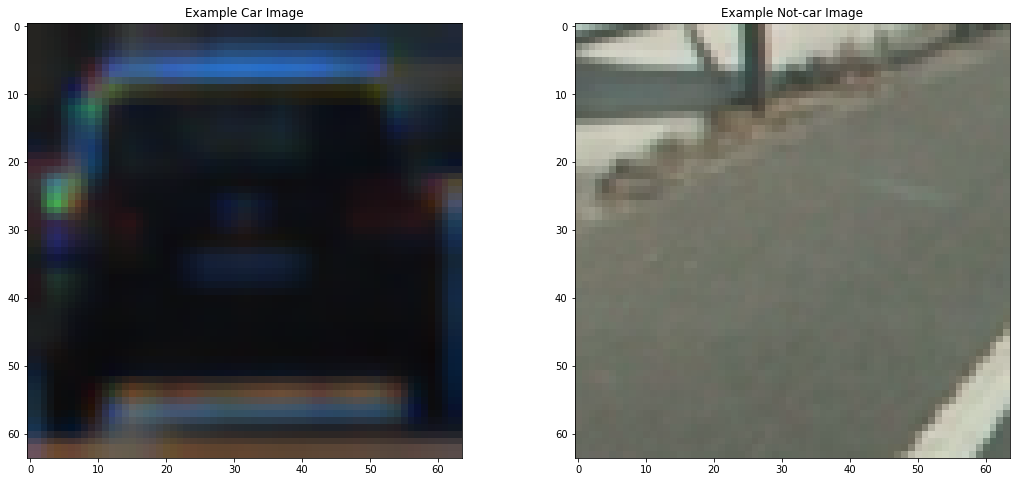

In [2]:
# Read non-vehicles and vehicles images
notcars = glob.glob('non-vehicles/*/*.png')
cars = glob.glob('vehicles/*/*.png')

data_info = data_look(cars, notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure(figsize=(18,8))
plt.subplot(121), plt.imshow(car_image), plt.title('Example Car Image')
plt.subplot(122), plt.imshow(notcar_image), plt.title('Example Not-car Image')

# 2. Histogram of Oriented Gradient (HOG) Features

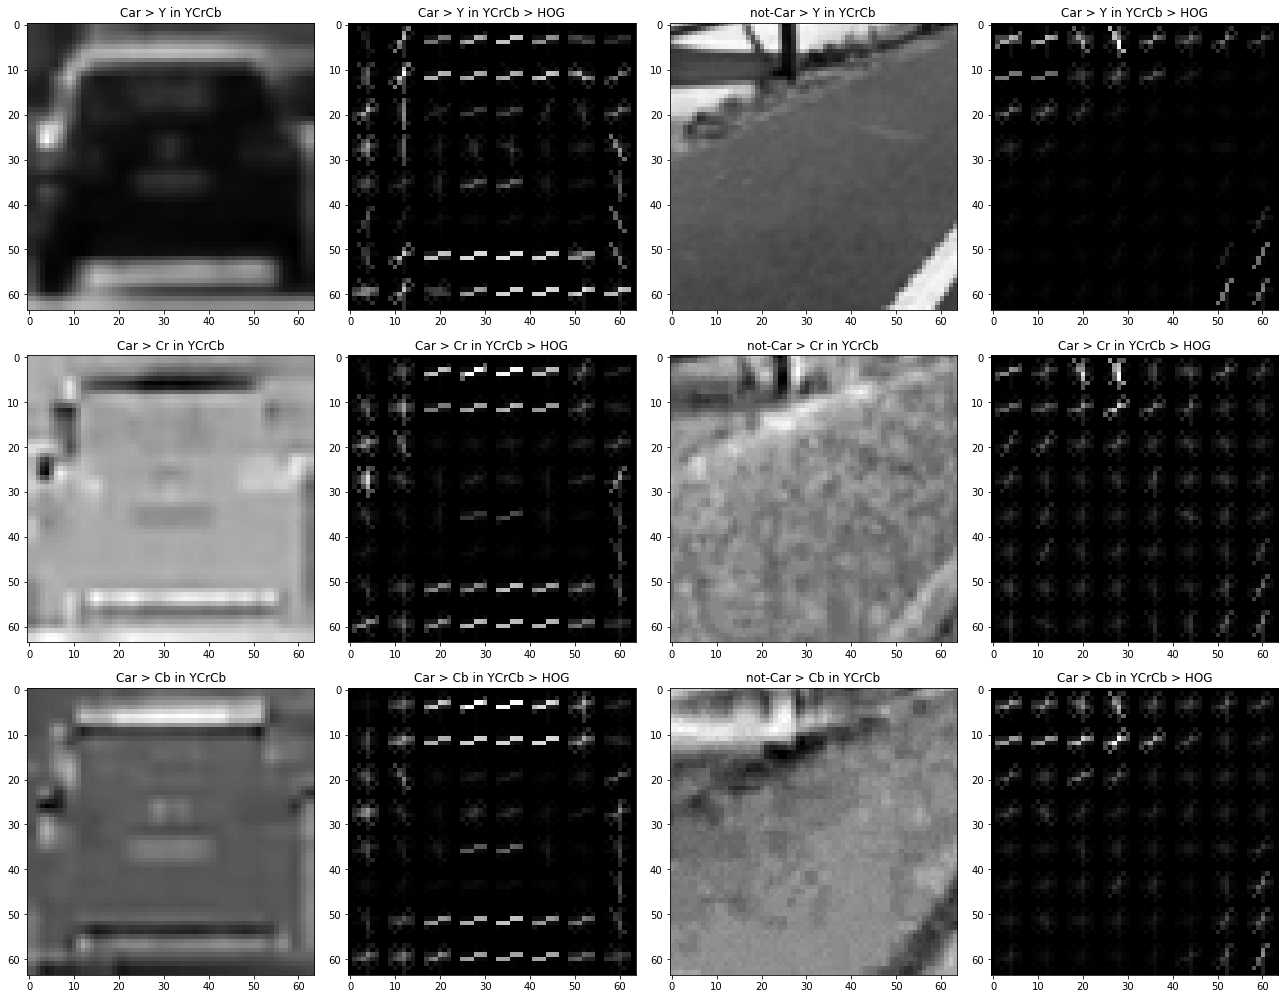

In [4]:
# Read in the image
car_YCrCb = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
notcar_YCrCb = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
features = []
hog_images = []
# Call our function with vis=True to see an image output
for i in range(car_YCrCb.shape[2]):
    _, hog_image = get_hog_features(car_YCrCb[:,:,i], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    hog_images.append(hog_image)
    _, hog_image = get_hog_features(notcar_YCrCb[:,:,i], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    hog_images.append(hog_image)

# Plot the examples
fig = plt.figure(figsize=(18,14))
plt.subplot(341), plt.imshow(car_YCrCb[:,:,0], cmap='gray'), plt.title('Car > Y in YCrCb')
plt.subplot(342), plt.imshow(hog_images[0], cmap='gray'), plt.title('Car > Y in YCrCb > HOG')
plt.subplot(343), plt.imshow(notcar_YCrCb[:,:,0], cmap='gray'), plt.title('not-Car > Y in YCrCb')
plt.subplot(344), plt.imshow(hog_images[1], cmap='gray'), plt.title('Car > Y in YCrCb > HOG')
plt.subplot(345), plt.imshow(car_YCrCb[:,:,1], cmap='gray'), plt.title('Car > Cr in YCrCb')
plt.subplot(346), plt.imshow(hog_images[2], cmap='gray'), plt.title('Car > Cr in YCrCb > HOG')
plt.subplot(347), plt.imshow(notcar_YCrCb[:,:,1], cmap='gray'), plt.title('not-Car > Cr in YCrCb')
plt.subplot(348), plt.imshow(hog_images[3], cmap='gray'), plt.title('Car > Cr in YCrCb > HOG')
plt.subplot(349), plt.imshow(car_YCrCb[:,:,2], cmap='gray'), plt.title('Car > Cb in YCrCb')
plt.subplot(3,4,10), plt.imshow(hog_images[4], cmap='gray'), plt.title('Car > Cb in YCrCb > HOG')
plt.subplot(3,4,11), plt.imshow(notcar_YCrCb[:,:,2], cmap='gray'), plt.title('not-Car > Cb in YCrCb')
plt.subplot(3,4,12), plt.imshow(hog_images[5], cmap='gray'), plt.title('Car > Cb in YCrCb > HOG')
fig.tight_layout()

# 3. Combine Features and Classify with SVM

In [4]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save svc and parameters to a pickle file
try:
    f = open('svc.p', 'wb')
    save = {
      'svc': svc,
      'scaler': X_scaler,
      'orient': orient,
      'pix_per_cell': pix_per_cell,
      'cell_per_block': cell_per_block,
      'spatial_size': spatial_size,
      'hist_bins': hist_bins
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', 'svc.p', ':', e)
    raise
    
statinfo = os.stat('svc.p')
print('Compressed pickle size:', statinfo.st_size)

100%|██████████| 8968/8968 [00:55<00:00, 162.43it/s]


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
82.88 Seconds to train SVC...
Test Accuracy of SVC =  0.991
Compressed pickle size: 197963


(<matplotlib.axes._subplots.AxesSubplot at 0x114e3eef0>,
 <matplotlib.text.Text at 0x142896940>)

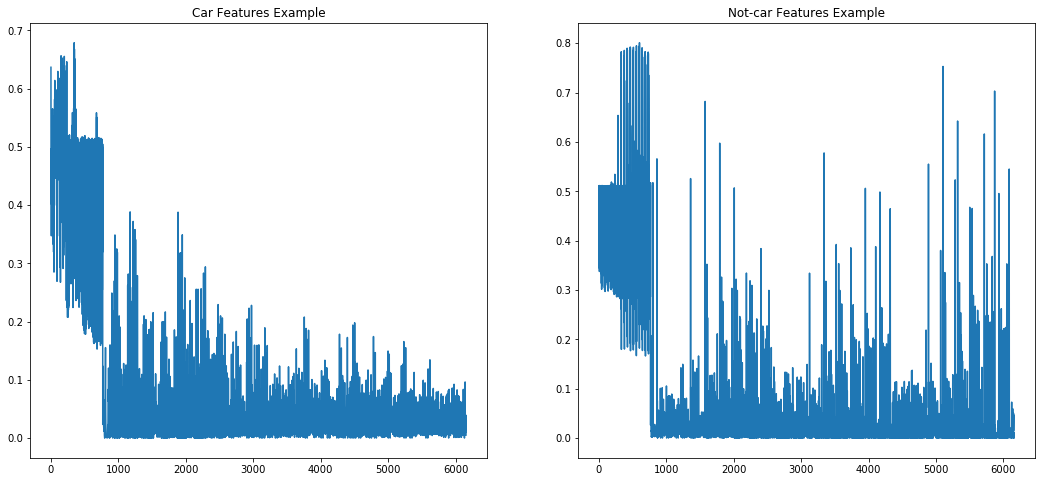

In [5]:
# Plot samples of features
fig = plt.figure(figsize=(18,8))
plt.subplot(121), plt.plot(car_features[car_ind]), plt.title('Car Features Example')
plt.subplot(122), plt.plot(notcar_features[notcar_ind]), plt.title('Not-car Features Example')

# 4. HOG Sub-sampling Window Search

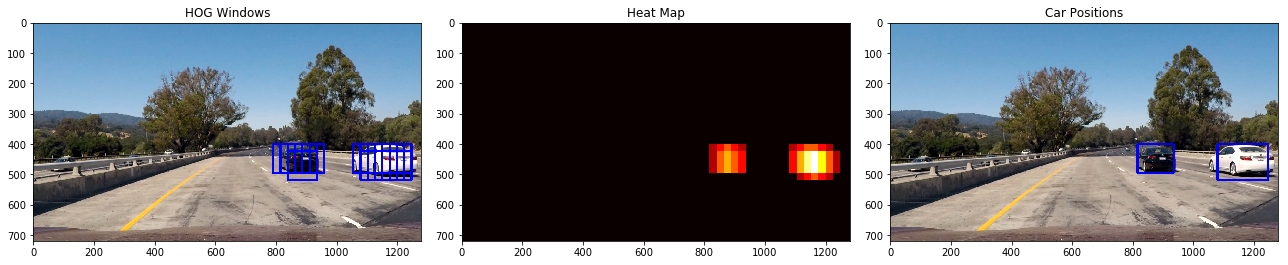

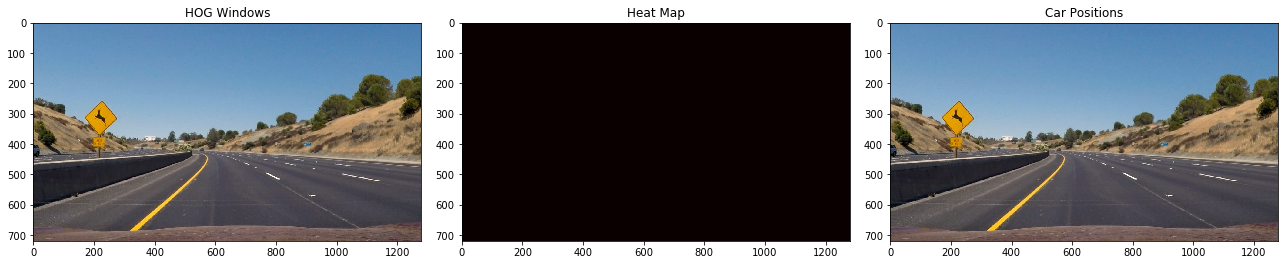

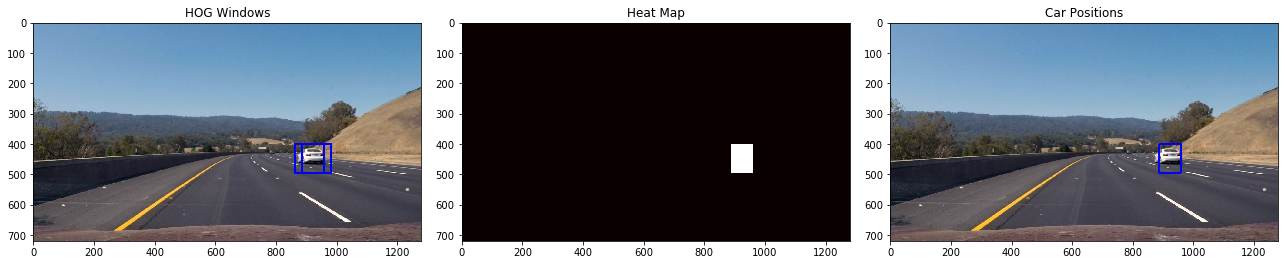

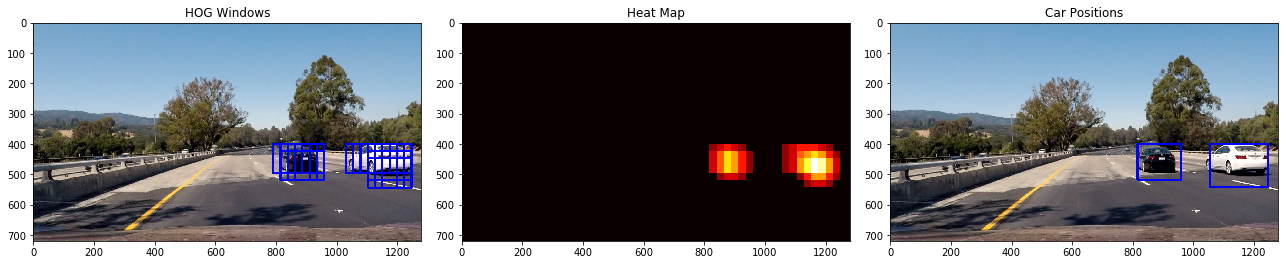

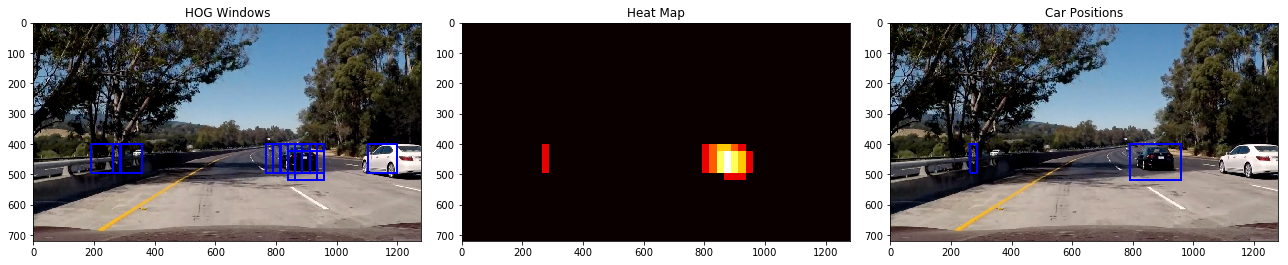

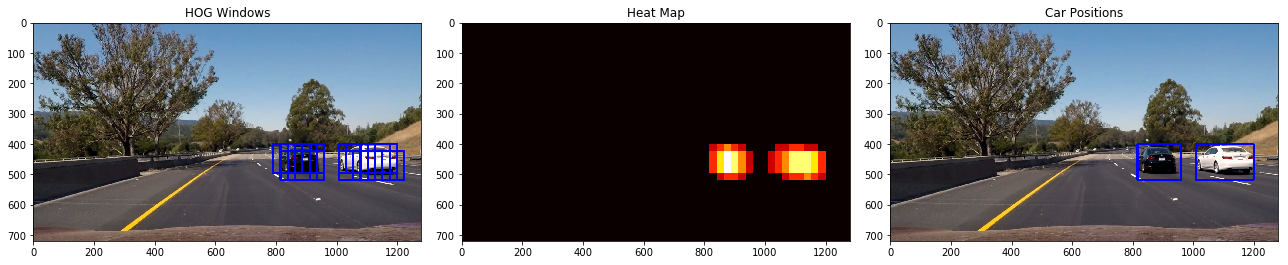

In [12]:
# Load data from the pickle file
with open('svc.p', 'rb') as f:
    dist_pickle = pickle.load(f)
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    del dist_pickle

im_list = glob.glob('test_images/*.jpg')

ystart = 400
ystop = 656
scale = 1.5

for img_name in im_list:
    img = mpimg.imread(img_name)
    out_img, box_list = find_cars(img, ystart, ystop, scale, 
                              svc, X_scaler, orient, pix_per_cell, 
                              cell_per_block, spatial_size, hist_bins)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, _ = draw_labeled_bboxes(np.copy(img), labels)
    
    fig = plt.figure(figsize=(18,8))
    plt.subplot(131), plt.imshow(out_img), plt.title('HOG Windows')
    plt.subplot(132), plt.imshow(heatmap, cmap='hot'), plt.title('Heat Map')
    plt.subplot(133), plt.imshow(draw_img), plt.title('Car Positions')
    fig.tight_layout()

# 5. Process Video

In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
from helper_functions import *
from scipy.ndimage.measurements import label
from Vehicles import *

with open('svc.p', 'rb') as f:
    dist_pickle = pickle.load(f)
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    del dist_pickle

ystarts = [400, 400, 400, 400]
ystops = [496, 528, 592, 656]
scales = [1., 1.25, 1.5, 1.75]

def process_image(img):
    return pipeline(img, cars, ystarts, ystops, scales,
                    svc, X_scaler, orient, pix_per_cell,
                    cell_per_block, spatial_size, hist_bins)

In [2]:
cars = Vehicles()
video_output = 'test_output.mp4'
clip1 = VideoFileClip('test_video.mp4')
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [00:06<00:00,  5.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 5.52 s, sys: 443 ms, total: 5.96 s
Wall time: 8.48 s


In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [4]:
cars = Vehicles()
video_output = 'project_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [03:52<00:00,  5.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 2min 59s, sys: 13.3 s, total: 3min 13s
Wall time: 3min 53s


In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [6]:
import numpy as np
temp = [[((3,4),(6,7))],
       [((5,2),(8,4))],
       [((4,7),(6,9))]]

print(np.min(temp[:][0][0]))

3


In [32]:
temp = [500, 600, 700]
temp2 = 689
mask = [(el > temp2) for el in temp]
print(mask)
print([(temp[i]) for i in range(len(temp)) if mask[i]])
print(temp)

[False, False, True]
[700]
[500, 600, 700]


In [33]:
temp = [500, 600, 700]
temp2 = 689
[temp2 if x>temp2 else x for x in temp ]

[500, 600, 689]